# Machine Learning for Physicists

## Emtropy

For any probability distribution we can calculate an entropy. It is a rouph measure of how spread out the probability distribution is. If it is very spread out over the various possibilities then the entropy is large if it is concentrated tightly in one of the possibilities then the entropy is small or even zero. So for any probability distribution given by probabilities $p_j$ we can have a entropy:

$S = - \sum_j p_j Ln p_j$

We define a cost function that looks like the entropy:

$C = -\sum_j y_j^{target} Ln y_j^{out}$.

If output of our neural network $y$ is representing a probability distribution and we want to compare it against a desired target probability distribution. We can set up a cost function of the sort that we have shown above. 
We use cross entropy because an entropy here compares two different probability distributions. It is categorical because we take categories of different labels as outputs. 

in keras :
net.compile(loss = "categorical_crossentropy").

Why do people like to combine these probability distributions that include sofmax construction with this categorical cross-entropy?

It is related to how the derivatives look like and how the training progresses. When we want to train we take the derivatives to calculate the update in the stochastic gradient descent and we need the derivatives of the output neurons with respect to the arguments that we put into output neurons. One of the problems that sigmoid has and the softmax is similar is that there is a long flat parts in these functions where they are saturated. Then a consequence of the derivative is zero. It is bad thing for the larger arguments. Because there is no training going on when arguments are larger.  

<div>
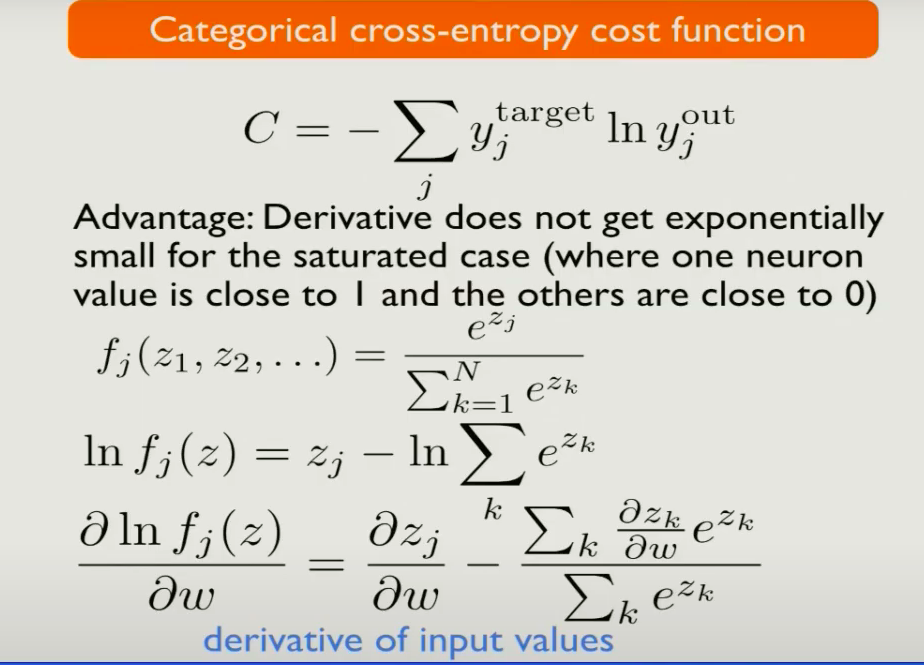
</div>

<div>
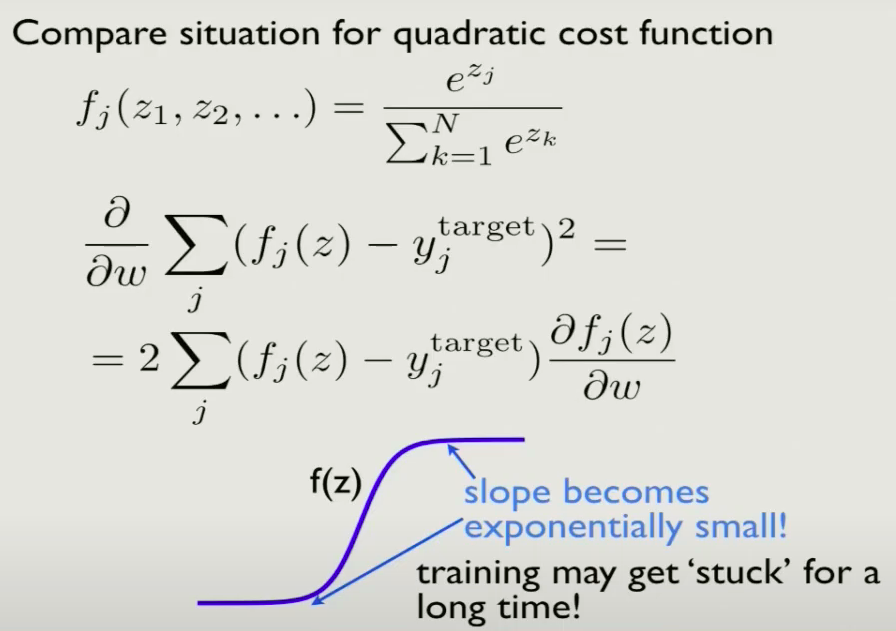
</div>


First we implement and train a simple NN using keras. 
The network has one input and one output and can be used to fit a 1D function.

In [3]:
# keras:
from tensorflow.keras import Sequential # Sequential is the neural-network class
from tensorflow.keras.layers import Dense # Dense is the standard network layer

# array math:
import numpy as np

# plotting:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

In [42]:
net = Sequential() # creating a neural network!
net.add(Dense(20,input_shape = (1,),activation='sigmoid')) # first hidden layer: 20 neurons (and 1 input neuron!)
net.add(Dense(10,activation='sigmoid'))# second hidden layer: 10 neurons
net.add(Dense(1,activation='linear'))# output layer: 1 neuron "relu"
# Compile network: (randomly initialize weights, choose advanced optimizer, set up everything!)
net.compile(loss='mean_squared_error', optimizer = 'adam')# adam is adaptive and works better than normal gradient descent

In [43]:
# run this cell multiple times to train the network better and better!

# a simple 1D function:
def my_target(y):
    #return( np.sin(y)/(1+y**2) ) # a wave packet...
    return(np.exp(y)/(1+np.exp(y)))
# training on a simple 1D function:

training_batches=200 # number of training batches
batchsize=20 # samples per batch
costs=np.zeros(training_batches) # array for storing costs

# run through all training batches:
for j in range(training_batches):
    y_in=np.random.uniform(low=-10.0,high=+10.0,size=[batchsize,1]) # get randomly scattered points (uniform distribution)
    y_target=my_target(y_in) # produce correct outputs (our target)
    costs[j]=net.train_on_batch(y_in,y_target) # train on this batch of samples
    print(str(costs[j]),end="   \r") # print current cost function, overwrite line always
 


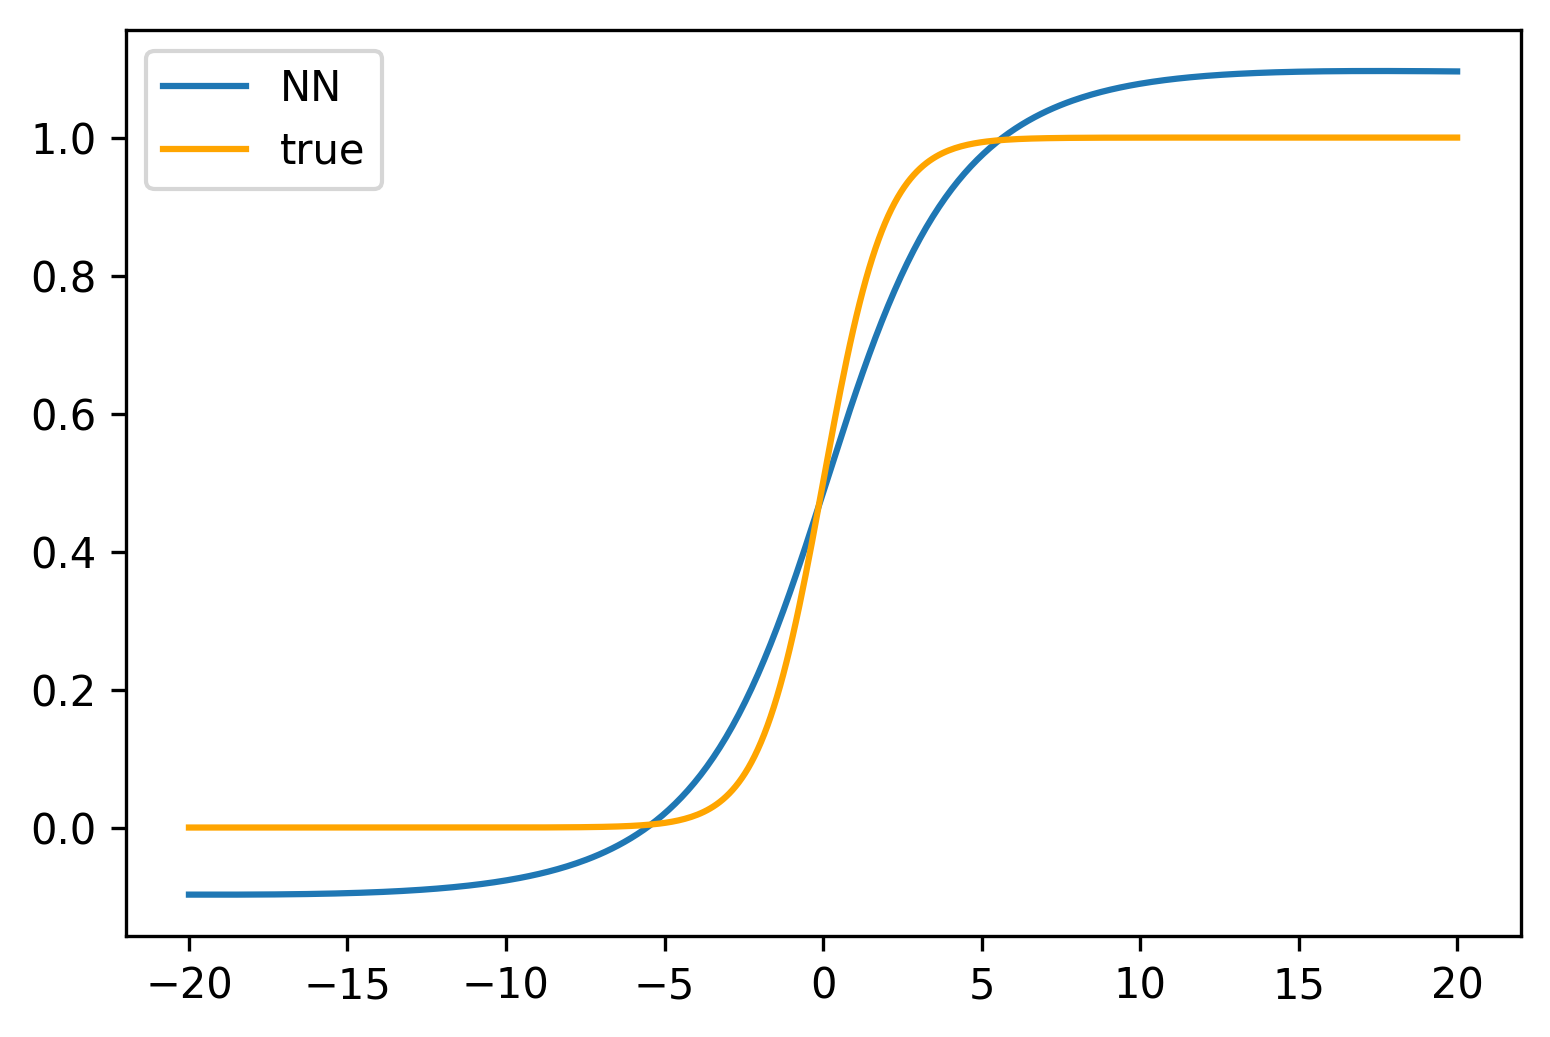

In [44]:
# now plot the output:

# get the output on a 1D grid of points:
N=400 # number of points
y_in=np.zeros([N,1]) # prepare correct shape for network, here N becomes the batch size
y_in[:,0]=np.linspace(-20.0,20.0,N) # fill with interval
y_out=net.predict_on_batch(y_in) # apply the network to this set of points!

# plot it!
plt.plot(y_in,y_out,label="NN")
plt.plot(y_in,my_target(y_in),color="orange",label="true")
plt.legend()
plt.show()

## Handwritten digits recognition

In [45]:
# Import keras library. Also import some of the layers, so we do not need to
# write things like "layers.Dense", but can just write "Dense" instead
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GaussianDropout
import tensorflow.keras.optimizers as optimizers

In [47]:
# Set up a random number generator with a fixed seed, so that
# running this whole notebook repeatedly should always give
# the same result (useful for debugging)
rng = np.random.RandomState(23455)

import time

In [48]:
"""
mnist_loader
~~~~~~~~~~~~

taken from Nielsen's online book:
http://neuralnetworksanddeeplearning.com/chap1.html


A library to load the MNIST image data.  For details of the data
structures that are returned, see the doc strings for ``load_data``
and ``load_data_wrapper``.  In practice, ``load_data_wrapper`` is the
function usually called by our neural network code.
"""

#### Libraries
# Standard library
import pickle
import gzip

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.

    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.

    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.

    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.

    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f,encoding='bytes')
    f.close()
    return (training_data, validation_data, test_data)

In [64]:
def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.

    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.

    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.

    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    
    global training_inputs, training_results
    global validation_inputs, validation_results
    global test_inputs, test_results
    global num_samples, numpixels, num_test_samples
    
    tr_d, va_d, te_d = load_data()
    
    num_samples=len(tr_d[0])
    training_inputs=np.zeros([num_samples,numpixels])
    training_results=np.zeros([num_samples,10])    
    for j in range(num_samples):
        training_inputs[j,:] = np.reshape(tr_d[0][j], (numpixels))
        training_results[j,:] = vectorized_result(tr_d[1][j])
#    validation_inputs = [reshape(x, (numpixels)) for x in va_d[0]]
#    validation_results = [vectorized_result(y) for y in va_d[1]]

    num_test_samples=len(te_d[0])
    test_inputs=np.zeros([num_test_samples,numpixels])
    test_results=np.zeros([num_test_samples,10])    
    for j in range(num_test_samples):
        test_inputs[j,:] = np.reshape(te_d[0][j], (numpixels))
        test_results[j,:] = vectorized_result(te_d[1][j])


In [65]:

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10))
    e[j] = 1.0
    return e

In [66]:
# initialize the network
def init_net():
    global net, numpixels
    net = Sequential()
    # note: batch_input_shape is (batchsize,timesteps,data_dim)
    net.add(Dense(30, input_shape=(numpixels,), activation='relu'))
    net.add(Dense(10, activation='softmax'))
    net.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1.0), metrics=['categorical_accuracy'])

In [67]:
# initialize the network
def init_net_large():
    global net, numpixels
    net = Sequential()
    # note: batch_input_shape is (batchsize,timesteps,data_dim)
    net.add(Dense(100, input_shape=(numpixels,), activation='relu'))
    net.add(GaussianDropout(0.1))
    net.add(Dense(50, activation='relu'))
    net.add(Dense(10, activation='softmax'))
    net.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1.0), metrics=['categorical_accuracy'])

In [89]:
def test_on(start,stop,dontprint=False):
    global test_inputs, test_results
    global net, predictions_probs, predictions, true_labels
    
    predictions_probs=net.predict_on_batch(test_inputs[start:stop,:])
    predictions=np.argmax(predictions_probs,axis=1)
    if dontprint==False:
        print("Predictions: ", predictions)
    true_labels=np.argmax(test_results[start:stop,:], axis=1)
    if dontprint==False:
        print("True labels: ", true_labels)

In [106]:
def display_image(which):
    global test_inputs
    
    plt.imshow(np.reshape(test_inputs[which,:],[28,28]),interpolation='nearest', cmap='binary')
    plt.show()

In [103]:
def display_image_array(which):
    global test_inputs
    
    numcolumns=8
    BigImage=np.zeros([28*numcolumns,28*numcolumns])
    for j in range(len(which)):
        x=(j%numcolumns)*28
        y=int(j/numcolumns)*28
        BigImage[x:x+28,y:y+28]=np.reshape(test_inputs[which[j],:],[28,28])
    plt.imshow(BigImage,interpolation='nearest', cmap='binary')
    plt.show()

In [104]:
def display_mistakes(maxnum):
    global test_inputs, rest_results, num_test_samples
    global true_labels, predictions, predictions_probs
    
    test_on(0,num_test_samples,dontprint=True)
    which=np.where(true_labels!=predictions)[0]
    for j in which:
        if j<maxnum:
            display_image(j)
            print("True ", true_labels[j], " - Predicted ", predictions[j], " with prob. ", predictions_probs[j,predictions[j]])

In [72]:
numpixels=784
load_data_wrapper() # load all the MNIST images

In [74]:
np.shape(training_inputs)

(50000, 784)

In [76]:
psi=training_inputs-np.sum(training_inputs,axis=0)/num_samples

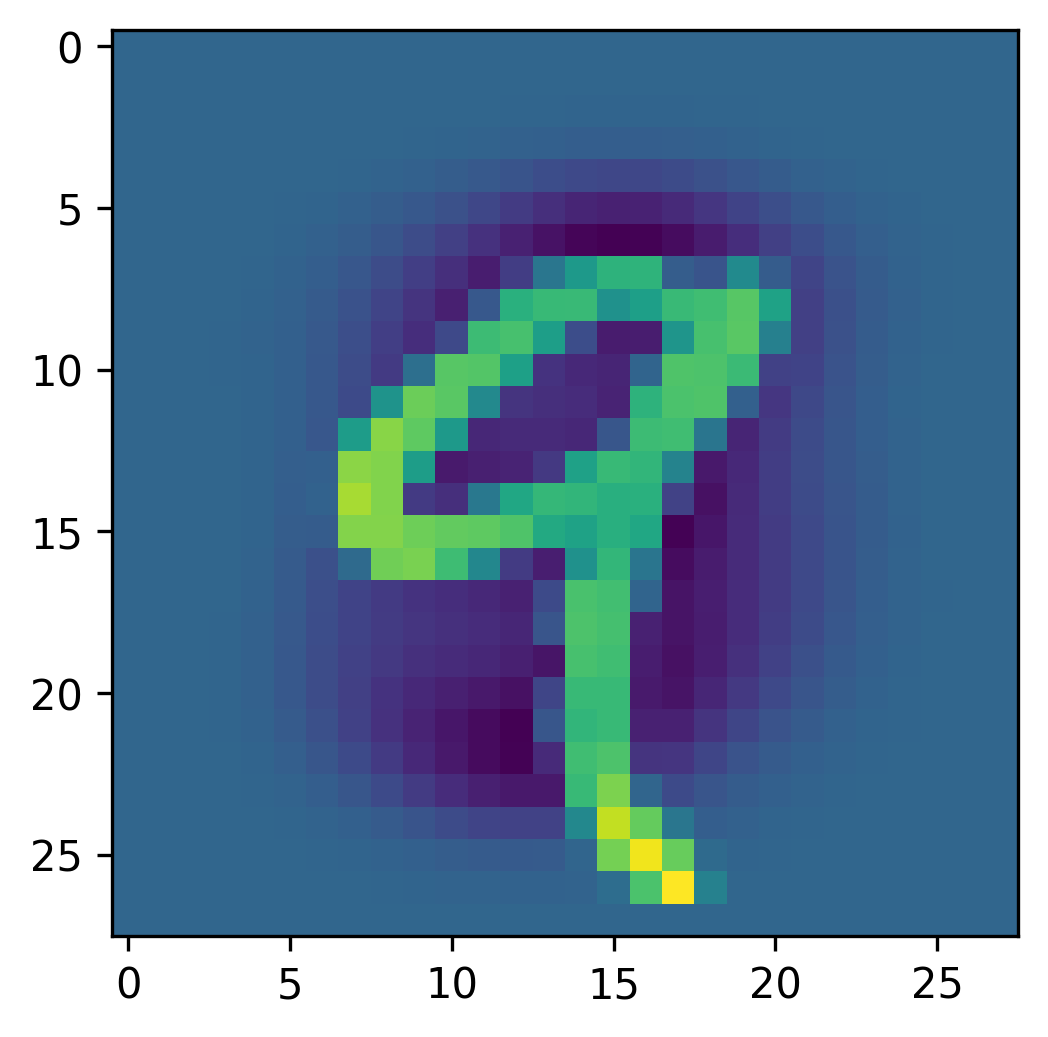

In [77]:
plt.imshow(np.reshape(psi[4,:],[28,28]))

In [78]:
np.shape(psi)

(50000, 784)

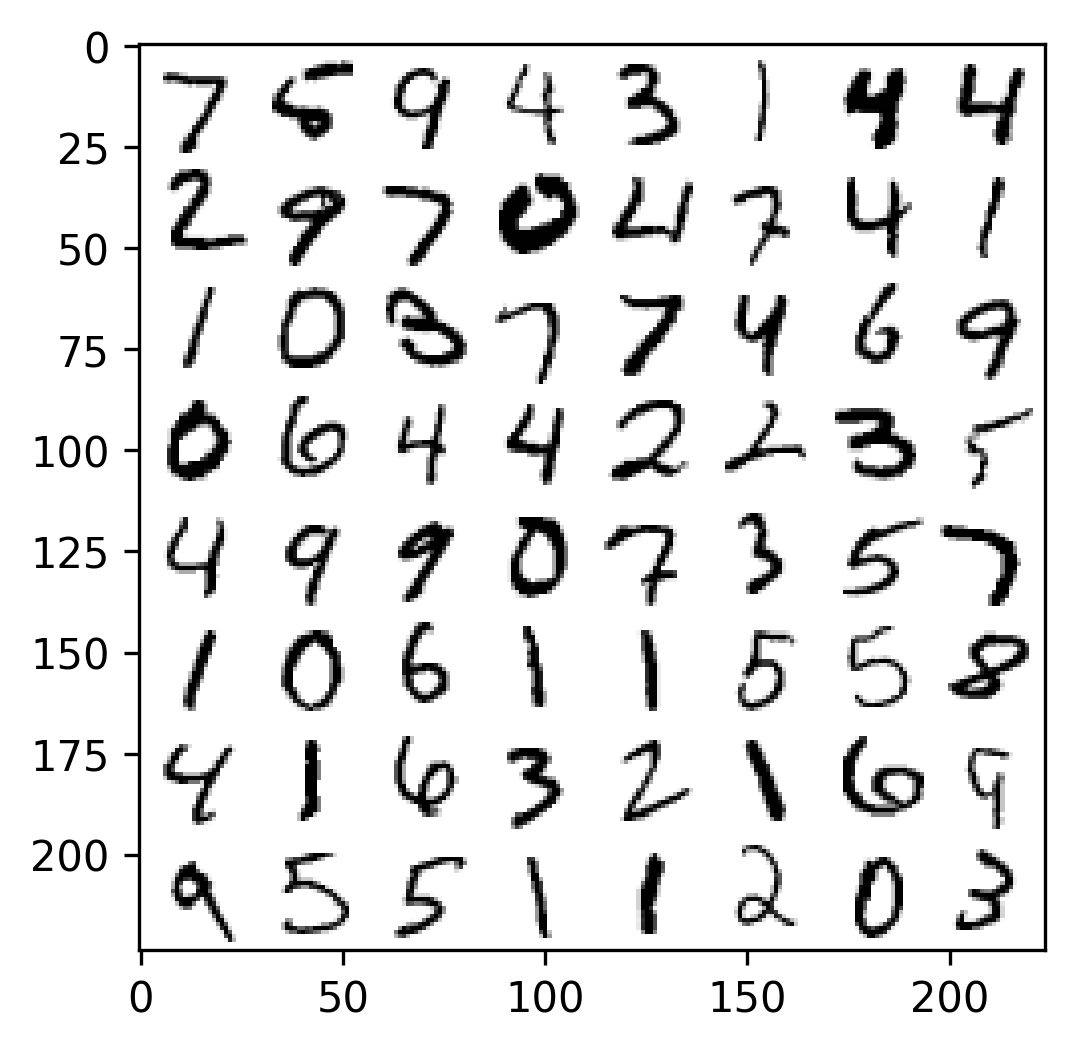

In [81]:
display_image_array(range(8*8))

In [82]:
np.shape(training_inputs)

(50000, 784)

In [83]:
init_net()

/Users/elham/opt/anaconda3/envs/vae2.0/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


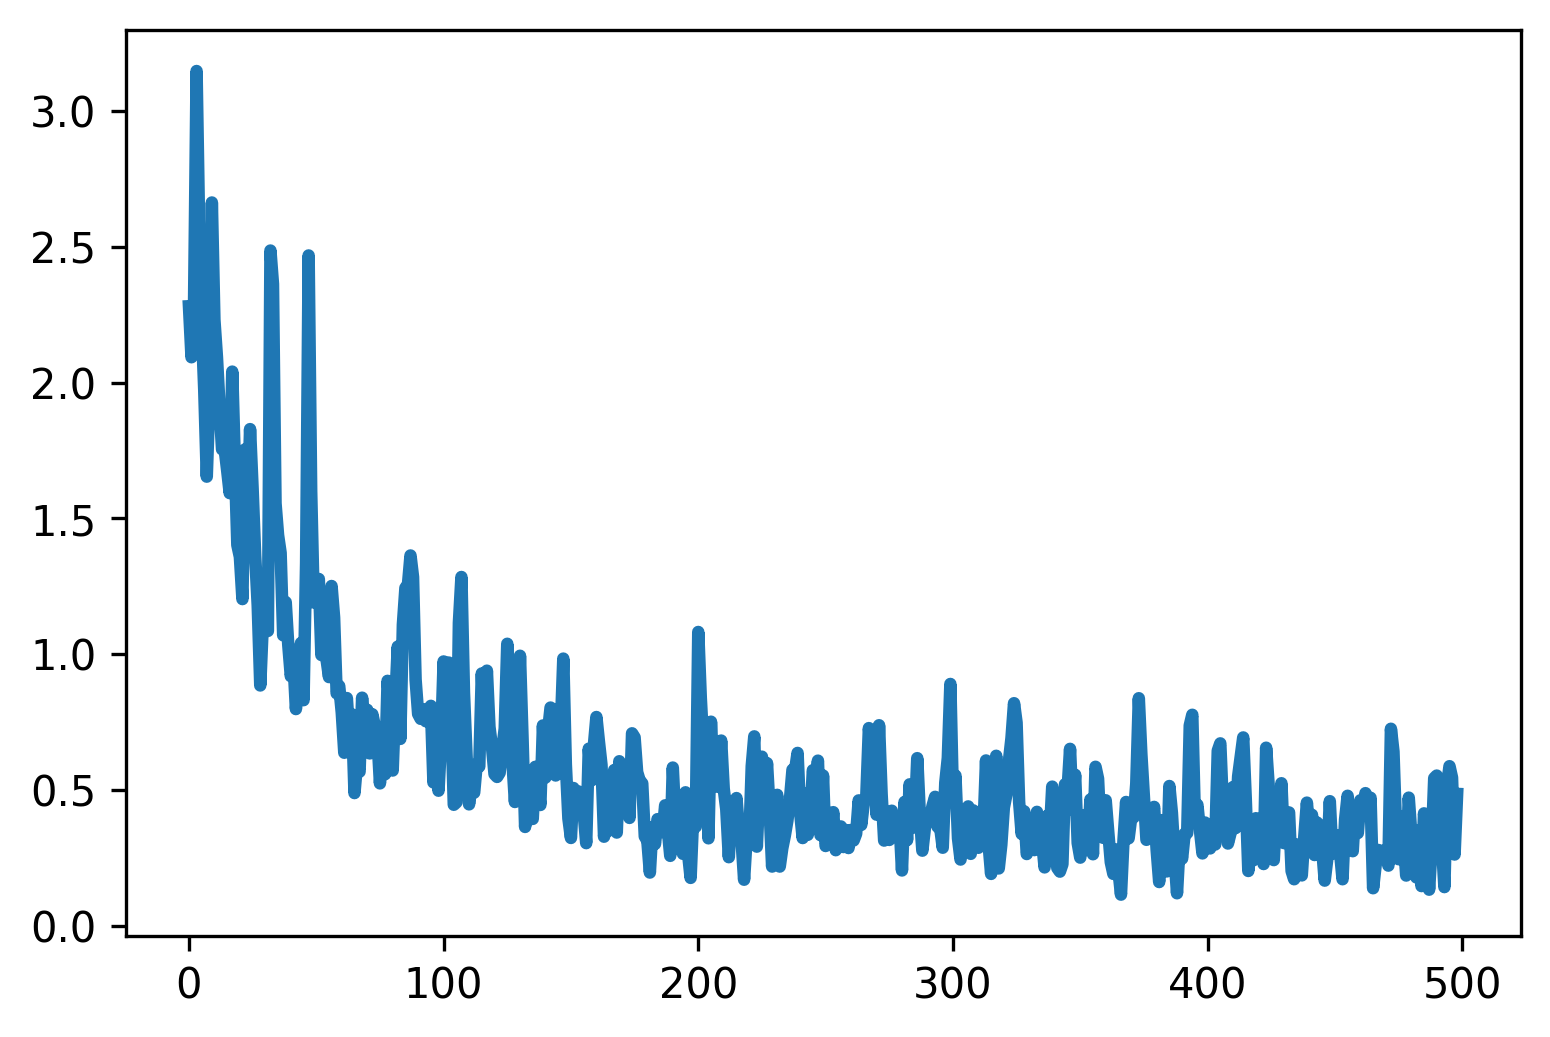

In [85]:
batchsize=100
batches=int(num_samples/batchsize)-1
costs=np.zeros(batches)
for j in range(batches):
    costs[j]=net.train_on_batch(training_inputs[j*batchsize:(j+1)*batchsize,:], training_results[j*batchsize:(j+1)*batchsize,:])[0]
plt.plot(costs,linewidth=3)
plt.show()

In [90]:
test_on(0,20)

Predictions:  [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
True labels:  [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [91]:
# use the keras "fit" function to go through the whole data set many times ('epochs'), 
# and even set aside some validation samples
history=net.fit(training_inputs,training_results,batch_size=100,
                epochs=30,validation_split=0.1)

Epoch 1/30
450/450 [==============================] - 1s 2ms/step - loss: 0.2806 - categorical_accuracy: 0.9195 - val_loss: 0.2648 - val_categorical_accuracy: 0.9226
Epoch 2/30
450/450 [==============================] - 1s 2ms/step - loss: 0.2497 - categorical_accuracy: 0.9283 - val_loss: 0.3197 - val_categorical_accuracy: 0.9056
Epoch 3/30
450/450 [==============================] - 1s 3ms/step - loss: 0.2254 - categorical_accuracy: 0.9350 - val_loss: 0.2875 - val_categorical_accuracy: 0.9200
Epoch 4/30
450/450 [==============================] - 2s 4ms/step - loss: 0.2162 - categorical_accuracy: 0.9374 - val_loss: 0.2527 - val_categorical_accuracy: 0.9228
Epoch 5/30
450/450 [==============================] - 2s 5ms/step - loss: 0.2063 - categorical_accuracy: 0.9400 - val_loss: 0.2507 - val_categorical_accuracy: 0.9262
Epoch 6/30
450/450 [==============================] - 1s 3ms/step - loss: 0.1955 - categorical_accuracy: 0.9424 - val_loss: 0.2303 - val_categorical_accuracy: 0.9342
Epoc

In [98]:
# see which fraction of the test samples is classified incorrectly
test_on(0,num_test_samples,dontprint=True)
which=np.where(true_labels!=predictions)[0]
print(len(which)/num_test_samples)

0.0601


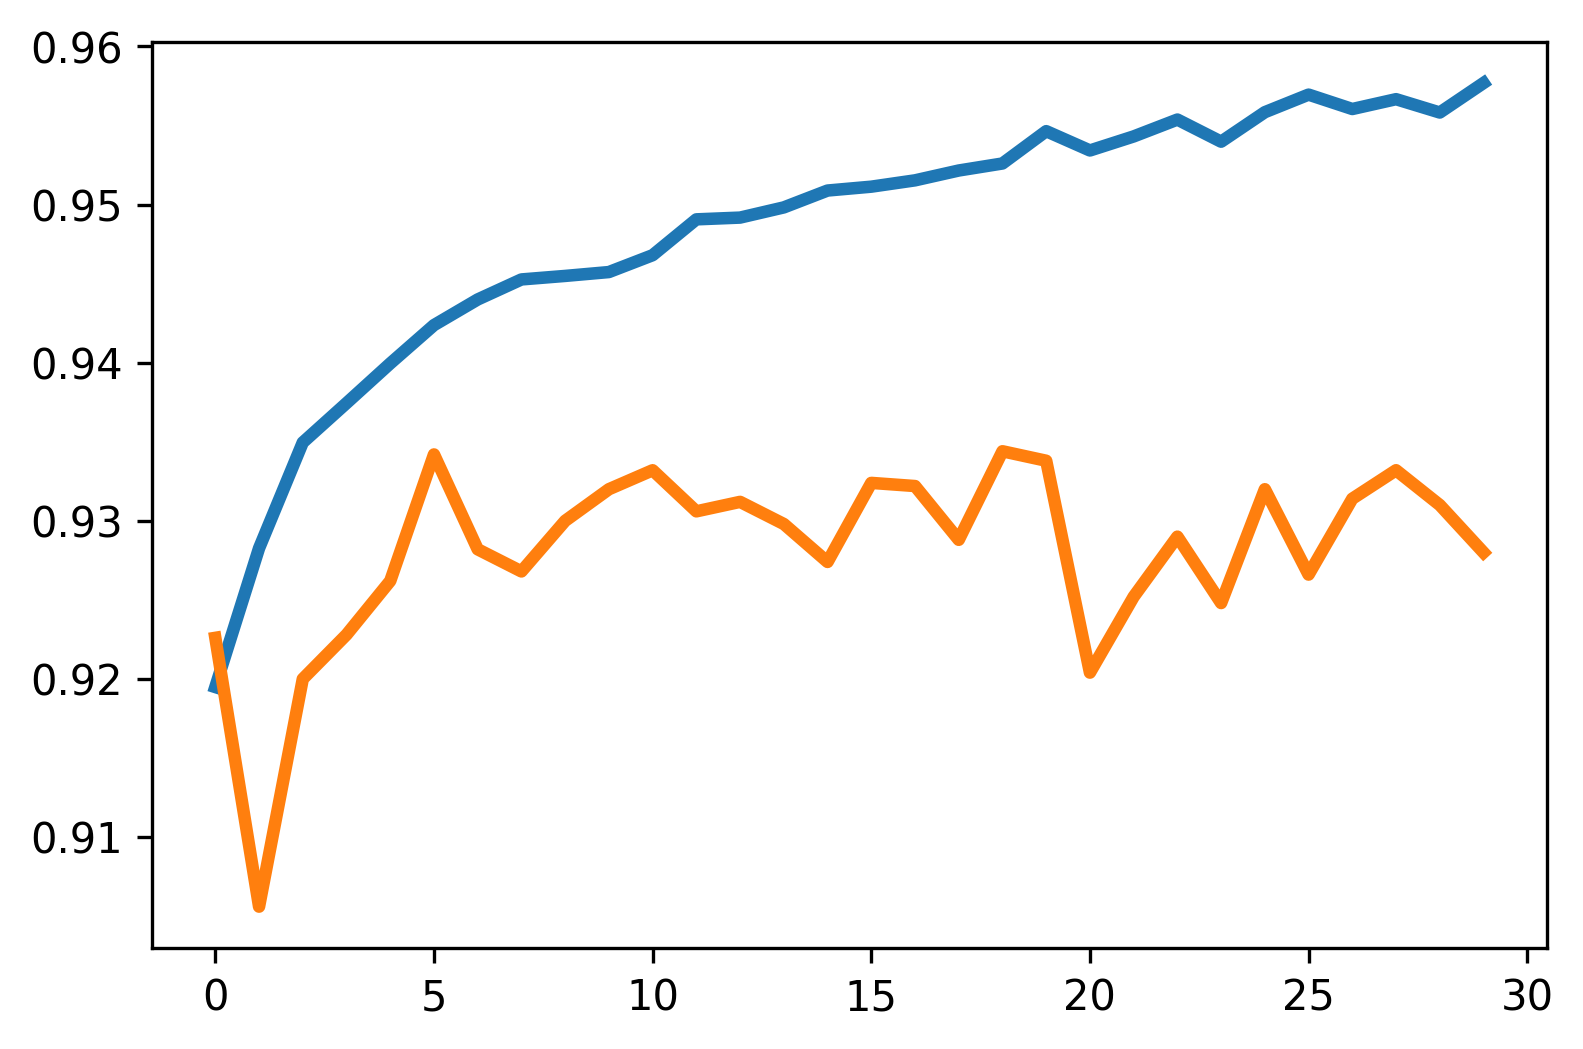

In [99]:
fig=plt.figure()
plt.plot(history.history['categorical_accuracy'], linewidth=3)
plt.plot(history.history['val_categorical_accuracy'], linewidth=3)
plt.show()

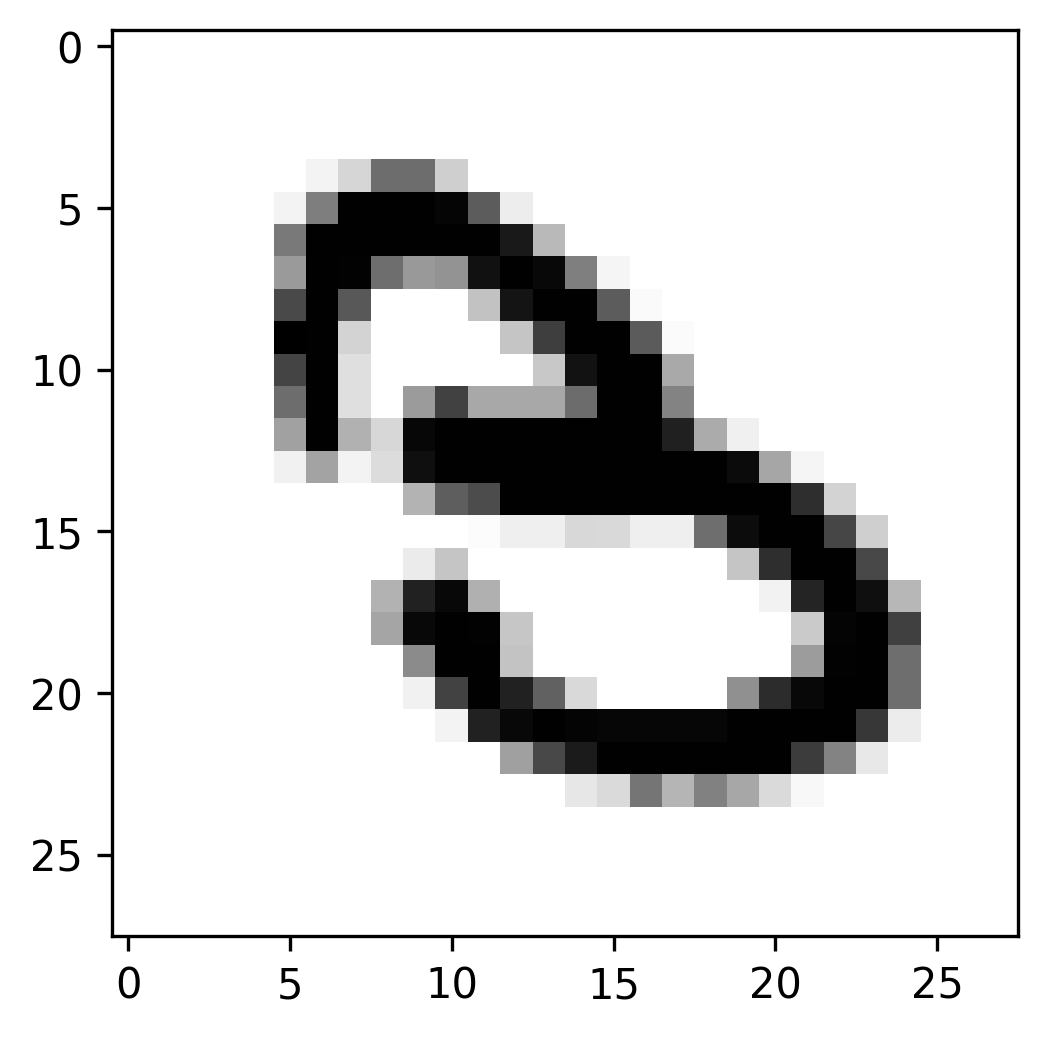

True  3  - Predicted  8  with prob.  0.9933507


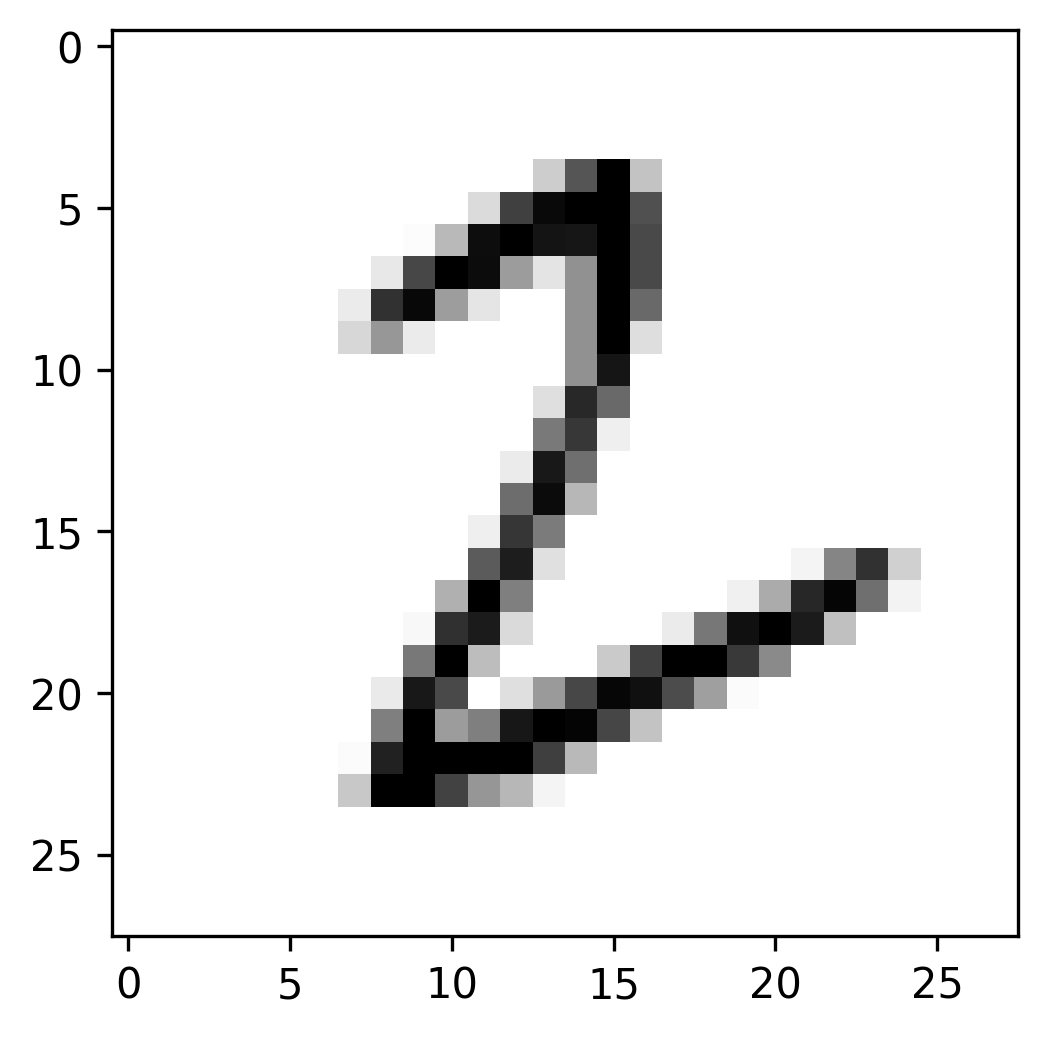

True  2  - Predicted  3  with prob.  0.5274166


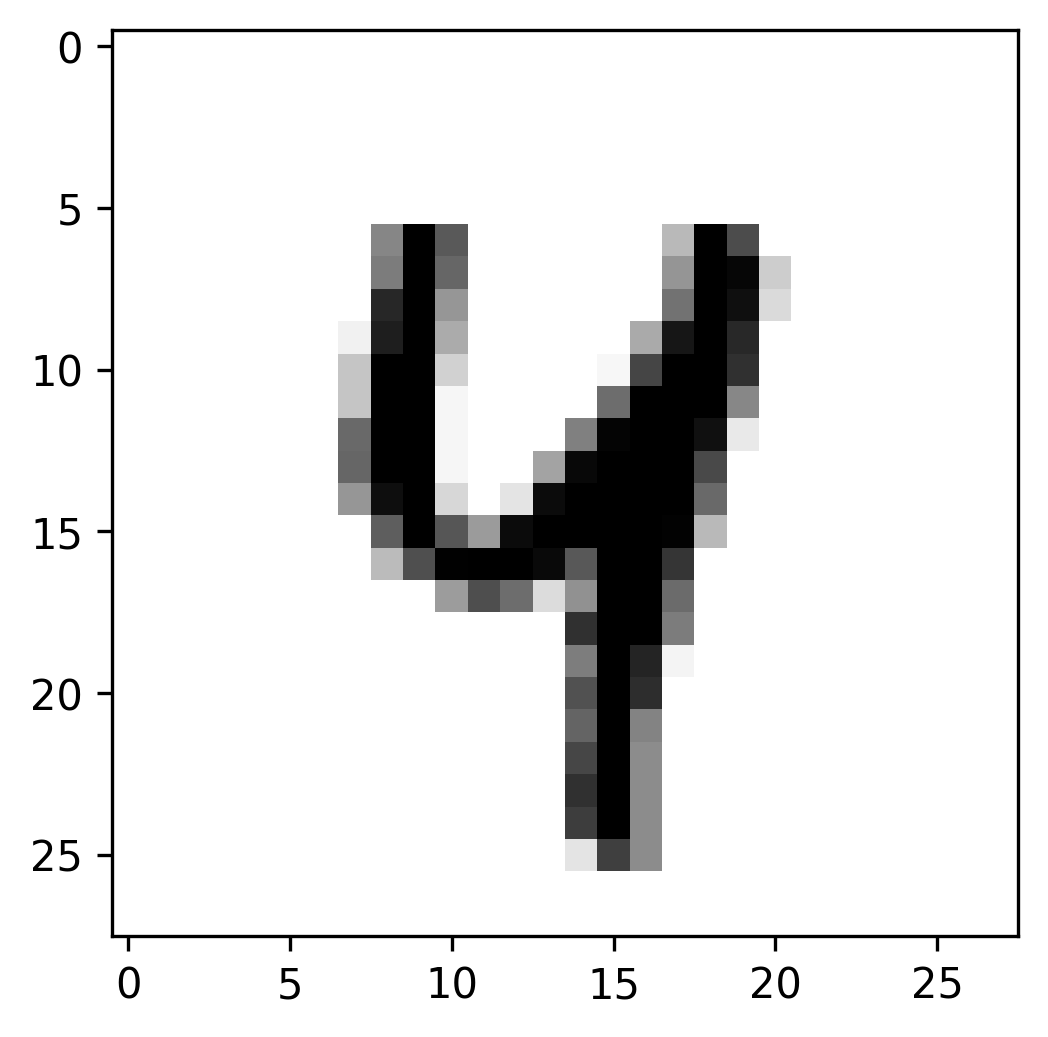

True  4  - Predicted  9  with prob.  0.77343464


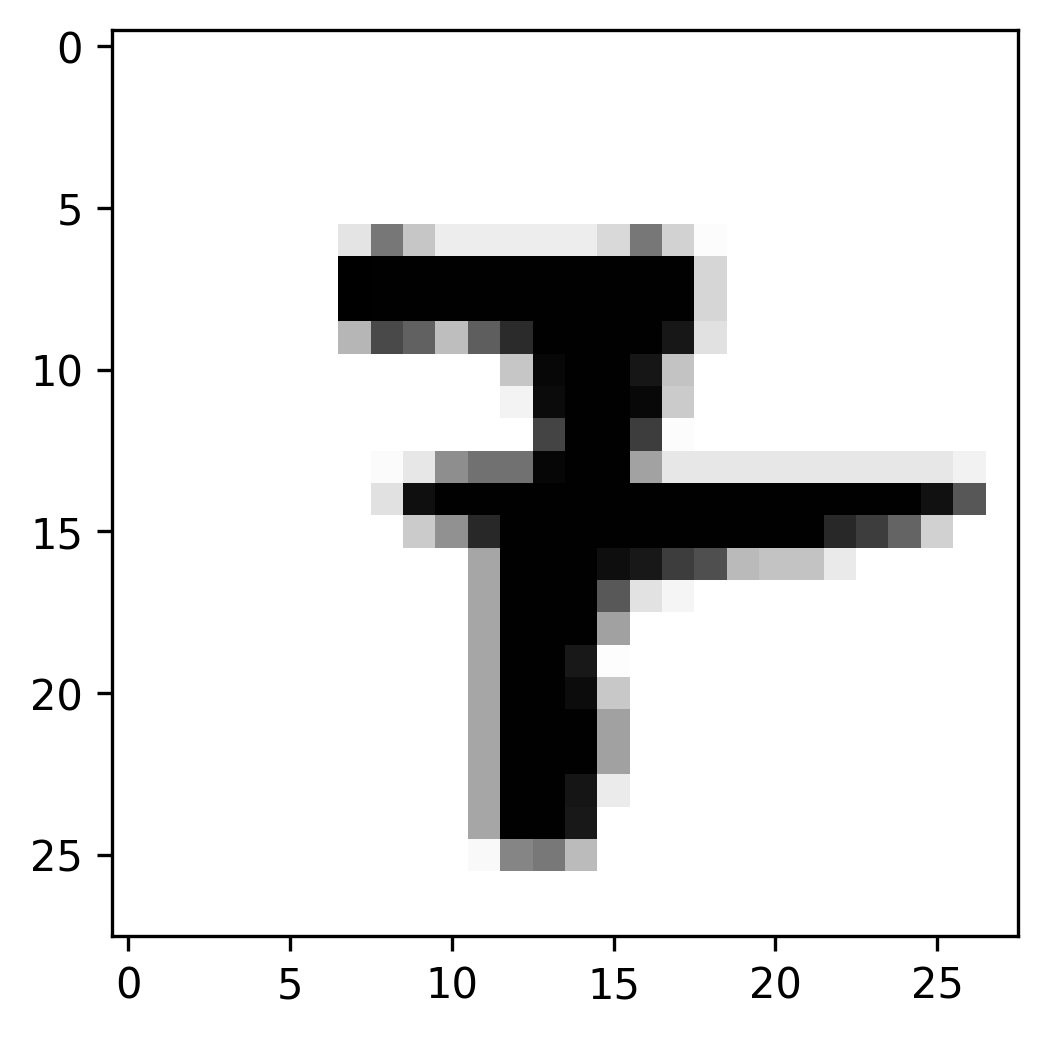

True  7  - Predicted  3  with prob.  0.88077736


In [107]:
display_mistakes(100)

We implemented NN with categorical cross entropy as cost function.We found that some images of digits were misclassified using NN. 
 The problem arises here is that assessing accuracy on thetraining set may yield results that are too otimistic. It needs to compare against sample which are not used for training to judge whethre the net can be generalize to unseen samples. 
If we only assess the quality on the training examples where we have already trained the network on then this is not giving us a fair assessment of the quality of the network. So what should we do?

We have a training set on which we train the network and we have a validation set which the network never sees for the training. We can use this to assess the accuracy of the network during the training. Independet on these two sets, there are the test sets.

We can see this behavior that the accuracy on training data increases over time as we train the net on train samples. However the accuracy on the validation data may level off at lower value and it might even decrease.

This is known as a overfitting. It happens when basically the network memorizes the training examples but it can not generalize to other samples. The solution is measure the accuracy against validation data independent of training data. We can stop the trainig after reaching maximum in validation accuracy ("early stopping"). We can generate new training data ("generate new images by distorting existing images"). We can use dropout, it means that we set to zero random neuron values during training.   

